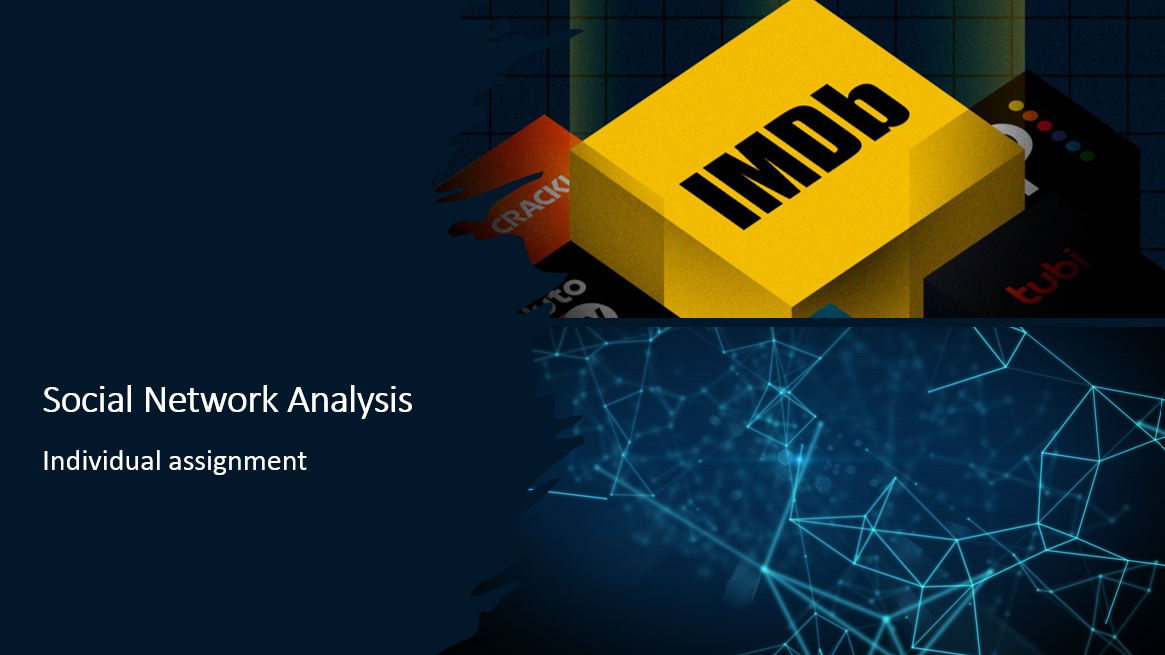

---



# Instructions
On this first assignment, applying the basic functions of the Igraph package is required. The following datasets are going to be used:

* Actors dataset - undirected graph - : For the 2005 Graph Drawing conference a data set was provided of the IMDB movie database. We will use a reduced version of this dataset, which derived all actor-actor collaboration edges where the actors co-starred in at least 2 movies together between 1995 and 2004. 


You have to complete the code chunks in this document but also analyze the results, extract insights and answer the short questions. Fill the CSV attached with your answers, sometimes just the number is enough, some others just a small sentence or paragraph. Remember to change the header with your email.

In your submission please upload both this document in HTML and the CSV with the solutions.




# Loading data


In this section, the goal is loading the datasets given

In [6]:
!pip install python-igraph
!apt-get install libcairo2-dev libjpeg-dev libgif-dev
!pip install pycairo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 36.6 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=abc6a40794b789201db0e529ce552e463b60b9f937ca003afe90fb421b535e55
  Stored in directory: /root/.cache/pip/wheels/dc/07/ac/bff79052fd6222d1239b228cd24a47222f227c2350f9c4df01
Successfully built python-igraph
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgif-dev is already the newest version (5.1.9-1).
libgif-dev set to manually installed.
libjpeg-dev is already the newest version (8c-2ubuntu8).
libjpeg-dev set to manually installed.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin liblzo2-2 libmount-dev libpixman-1-dev libselinux1-

In [7]:
from igraph import *
import cairo
import pandas as pd

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df_edges = pd.read_csv('/content/drive/MyDrive/SNA/imdb_actor_edges_sol.csv',sep = ';')

In [15]:
df_edges

from      to  weight
0       n17776  n17778       6
1        n5578   n9770       3
2        n5578    n929       2
3        n5578   n9982       2
4        n1835   n6278       2
...        ...     ...     ...
287069   n4462  n12854       2
287070   n4462  n10542       2
287071   n4462   n4475       2
287072   n4462  n10498       3
287073   n4462  n12075       3

[287074 rows x 3 columns]

In [16]:
df_nodes = pd.read_csv('/content/drive/MyDrive/SNA/imdb_actors_key_sol.csv', sep=';')

# Data Cleaning

As the provided node dataset contains some stacked information we need to clean the data first

The function below takes quite a long time to modify the df_nodes, the alternative is to load the df_nodes2 directly, which contains the processes genre types and genre counts

In [17]:
'''This function breaks the genres into columns and counts the genres in total in the genre_count'''


def split_genres(df):
    # A set to store the unique genre names
    genre_names = set()

    # checking for each row and splitting by comman
    for i, row in df.iterrows():
        # Split the genres column into a list of genre strings by the commas
        genres = row['genres'].split(',')
        
        # Loop through each genre string and extract the genre name, ignore genre "NULL"
        for genre_str in genres:
            genre_name, count = genre_str.split(':')
            if genre_name != 'genre' and genre_name != 'NULL':
              #add to genre_name to the set genre names
                genre_names.add(genre_name)
    
    # Create an empty dataframe to store the genre counts with columns of id, actor name and the genre count, adding genre names extracted before
    genre_df = pd.DataFrame(columns=['id', 'ActorName', 'genre_count'] + sorted(list(genre_names)))

    # Loop through each row in the dataframe
    for i, row in df.iterrows():
        # Replace NaN values with 0
        row = row.fillna(0)
        
        # Split the genres column into a list of genre strings
        genres = row['genres'].split(',')
        
        # Create a dictionary to store the genre counts for this row
        genre_counts = {}
        total_genre_count = 0

        # Fill NaN values with 0 in the genre_counts dictionary
        genre_counts = dict.fromkeys(sorted(list(genre_names)), 0)
        
        # Loop through each genre string and extract the genre and count
        for genre_str in genres:
            genre_name, count = genre_str.split(':')
            if genre_name != 'NULL':
                if int(count) > 0:
                    genre_counts[genre_name] = 1
                total_genre_count += genre_counts[genre_name]
        
        # Add the genre counts and total count to the genre dataframe
        genre_counts['id'] = row['id']
        genre_counts['ActorName'] = row['ActorName']
        genre_counts['movies_95_04'] = row['movies_95_04']
        genre_counts['main_genre'] = row['main_genre']
        genre_counts['genre_count'] = total_genre_count
        genre_counts['imbd_id'] = row['id'] #we include the id column again as it seems to vanish during creating the graph later on
        genre_df = genre_df.append(genre_counts, ignore_index=True)
    
    return genre_df

In [18]:
#applying the function to the dataframe with nodes
df_nodes2 = split_genres(df_nodes)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
<ipython-input-17-eadc73fd8d88>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genre_df = genre_df.append(genre_counts, ignore_index=True)
<ipython-input-17-eadc73fd8d88>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genre_df = genre_df.append(genre_counts, ignore_index=True)
<ipython-input-17-eadc73fd8d88>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genre_df = genre_df.append(genre_counts, ignore_index=True)
<ipython-input-17-eadc73fd8d88>:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  genre_df = genre_df.append(genre_counts, ignore_index=True)
<ipython-

In [19]:
df_nodes2

id            ActorName genre_count Action Adult Adventure  \
0      n15629  Rudder, Michael (I)           9      1     0         0   
1       n5026        Morgan, Debbi           5      0     0         0   
2      n11252         Bellows, Gil          10      0     0         0   
3       n5150         Dray, Albert           7      0     0         0   
4       n4057      Daly, Shane (I)           8      0     0         0   
...       ...                  ...         ...    ...   ...       ...   
17572  n16211     Urrutia, Paulina           4      0     0         0   
17573   n4910        Kay, Lisa (I)           4      0     0         0   
17574   n5746   Sutherland, Kiefer          12      1     0         0   
17575   n1645         Glyde, Billy           4      0     1         0   
17576   n8474        Scott, Ridley           3      0     0         0   

      Animation Comedy Crime Documentary  ... Mystery Romance Sci-Fi Short  \
0             0      1     0           0  ...       0       1      1     0   
1             0      1     0           1  ...       0       1      0     0   
2             0      1     0           1  ...       1       1      0     1   
3             0      1     1           1  ...       0       1      0     1   
4             0      1     1           0  ...       0       1      0     0   
...         ...    ...   ...         ...  ...     ...     ...    ...   ...   
17572         0      1     0           0  ...       0       1      0     1   
17573         0      1     0           0  ...       0       1      0     0   
17574         0      1     0           1  ...       0       0      1     1   
17575         0      0     0           0  ...       0       0      1     1   
17576         0      0     0           1  ...       0       0      0     1   

      Thriller War Western imbd_id main_genre movies_95_04  
0            1   1       0  n15629   Thriller         12.0  
1            0   0       0   n5026      Drama         16.0  
2            1   0       0  n11252      Drama         33.0  
3            1   0       0   n5150     Comedy         20.0  
4            1   0       0   n4057      Drama         18.0  
...        ...  ..     ...     ...        ...          ...  
17572        0   0       0  n16211    Romance         10.0  
17573        0   0       0   n4910     Comedy         10.0  
17574        1   1       1   n5746      Drama         43.0  
17575        0   0       0   n1645      Adult        182.0  
17576        0   0       0   n8474     Family         24.0  

[17577 rows x 26 columns]

# Graph creation


The graph is created using the igraph library. The actors are the nodes, their interaction are the edges. All attributes come on top to group  into subgraphs or communities

In [20]:
import igraph as ig

In [21]:
g = ig.Graph.DataFrame(edges=df_edges, vertices=df_nodes2, directed=False, use_vids=False) 

# Graph overview


In [22]:
# Get a summary of the graph
summary = g.summary()

# Print the summary
print(summary)

IGRAPH UNW- 17577 287074 -- 
+ attr: Action (v), ActorName (v), Adult (v), Adventure (v), Animation (v), Comedy (v), Crime (v), Documentary (v), Drama (v), Family (v), Fantasy (v), Horror (v), Music (v), Musical (v), Mystery (v), Romance (v), Sci-Fi (v), Short (v), Thriller (v), War (v), Western (v), genre_count (v), imbd_id (v), main_genre (v), movies_95_04 (v), name (v), weight (e)


In [23]:
# Get the number of edges
num_edges = g.ecount()

# Print the result
print(f"The number of edges in the graph is: {num_edges}")

The number of edges in the graph is: 287074


In [15]:
# Get the number of nodes
num_nodes = g.vcount()

# Print the result
print(f"The number of nodes in the graph is: {num_nodes}")

The number of nodes in the graph is: 17577




---



## **Answers Q1&2**


1) How many nodes are there? The number of nodes in the graph is 17577

2) How many edges are there? The number of edgedes in the graph is 287074



---



## Visualization of graph

Next up we visualize the entire graph. The visualiztion is first done in Gephi and subgraphs are created using the modularity fuction. After that the file is exported in the gefx. format and uploaded to the webtool "Retina". This is how the file is displayed on retina showing different communities. The colorful points represent the different nodes, each color is a different communities. They are connected by edges which are colored in grey. We can see that most communities are interconnected into one graph. We can also see that are single subgraphs on the outer border (nodes of 2 or 3 connected with each other but no other values

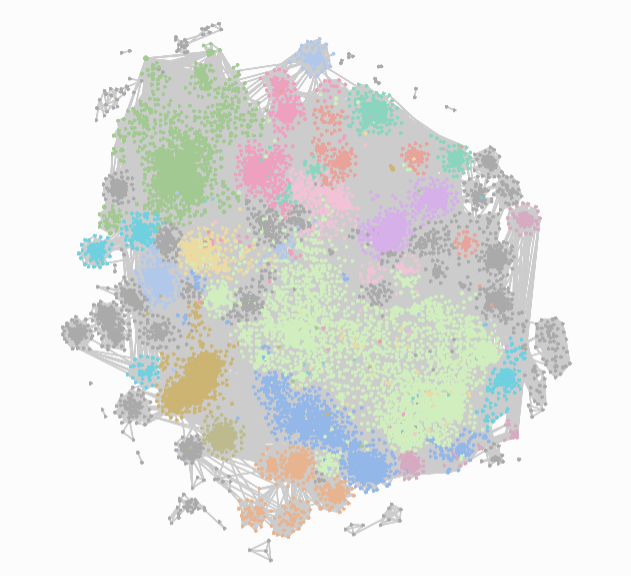

Now that we have a idea of the overall graph let's zoom in some of the communities. We are filtering for the four communities with the highest amount of nodes. The interpretation of the communities with the highest node share was done by looking at some of the attributes that are common among different nodes in the community. This was not done systematically, but rather by randomly checking around 10 nodes and there attributes. The communities with the highest node share were:

1.   American Movie industry - 23% of  nodes (was grouped due the high amount of English sounding names in this community and done research that links them only to English speaking movies from the US)
2.   Adult Movie industry - 10% of all nodes (all nodes observed in this community had the genre adult)
3.   French/Spanish Movie industry- 7% of nodes (was grouped to the high amount of French or Spanish names in this community)
4.   Germany movie industry- 8% of nodes (was grouped due to high amount of German names in this community) 





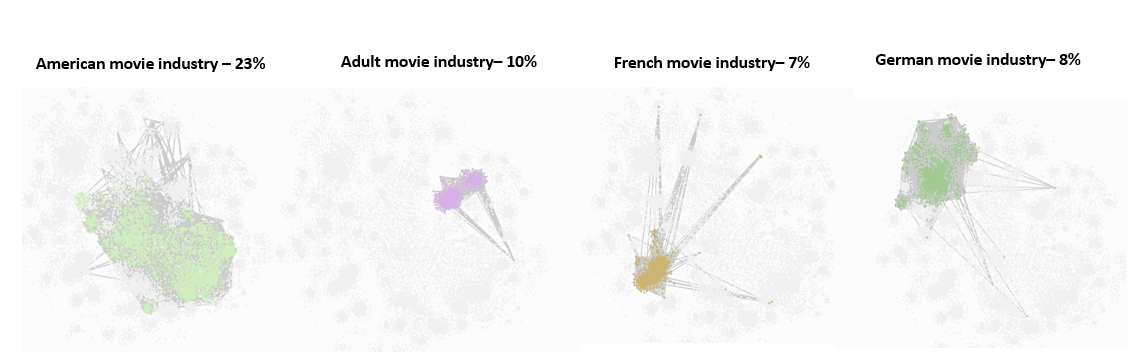



---
# Degree distribution


Analyse the degree distribution. Compute the total degree distribution.

**3) How does this distributions look like?**

**4) What is the maximum degree?**

**5) What is the minum degree?**

In [16]:
# Get the degree distribution
degree_dist = g.degree_distribution()

# Print the degree distribution
print(degree_dist)

N = 17577, mean +- sd: 32.6647 +- 47.6304
Each * represents 11 items
[  1,   2): ******************************************* (475)
[  2,   3): ****************************************************** (597)
[  3,   4): ********************************************************* (634)
[  4,   5): ************************************************************** (683)
[  5,   6): *********************************************************** (655)
[  6,   7): ************************************************************ (664)
[  7,   8): ************************************************************ (661)
[  8,   9): ***************************************************** (585)
[  9,  10): ****************************************************** (604)
[ 10,  11): ************************************************** (553)
[ 11,  12): *********************************************** (521)
[ 12,  13): ******************************************** (485)
[ 13,  14): ************************************* (411)
[ 14

In [17]:
import plotly.graph_objs as go
import plotly.io as pio
import numpy as np

degree1 = g.degree(mode='all')
hist, edges = np.histogram(degree1, range=(min(degree1), max(degree1)), bins=max(degree1)-min(degree1))

fig = go.Figure(
    data=[go.Bar(x=edges[:-1], y=hist)],
    layout=go.Layout(
        title='Distribution of Degree',
        xaxis=dict(title='Degree'),
        yaxis=dict(title='Frequency'),
    )
)

pio.show(fig)

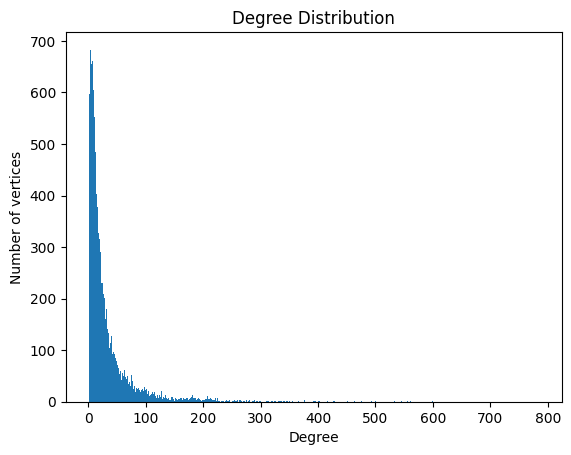

In [18]:
import matplotlib.pyplot as plt 
degrees = g.degree()

# Plotting the degree distribution as a histogram
plt.hist(degrees, bins=range(max(degrees)+2))
plt.xlabel('Degree')
plt.ylabel('Number of vertices')
plt.title('Degree Distribution')
plt.show()

In [25]:
# Calculate the minimum and maximum degree
min_degree = min(degrees)
max_degree = max(degrees)

# Print the results
print("Minimum degree:", min_degree)
print("Maximum degree:", max_degree)

NameError: ignored

In [24]:
# find all disconnected components in the graph
components = g.decompose()

# print the number of disconnected components found
print("Number of disconnected components:", len(components))

# print the subgraphs representing each disconnected component
for i, component in enumerate(components):
    print("Component", i+1, ":", component)

Number of disconnected components: 19
Component 1 : 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



We have in total 19 subgraphs. 

---



## **Answers Q3,4,5**


3) How does this distributions look like? Most of the degrees are between 0 and 50. The rest is between 50 and 100. Only a couple of nodes have a higher centrality degree. The curve follows a logarithmic normal distribution pattern. 

4) What is the maximum degree? The maximum degree is 784

5)What is the minimum degree? The minimum degree is 1



---



# Network Diameter and Average Path Length

You have functions in igraph to calculate the diameter and the average path length. Think if you should consider the weights, the directions, etc.

**6) What is the diameter of the graph?**

**7) What is the avg path length of the graph?** 

To answer these question we use besides the main method of iGraph also NetworkX and Gephi as the level of connectness of a graph is accounted different for each of those methods

## **iGraph**

In [11]:
# Calculating the diameter of the graph and printing it
diameter = g.diameter()
print("The diameter of the graph is:", diameter)

NameError: ignored

In [21]:
# Calculate the average shortest path length in the graph and printing it
avg_path_length = g.average_path_length()
print("The average shortest path length is:", avg_path_length)

The average shortest path length is: 4.890545545798965


## **Networkx**

At the same time it was  tried in parallel to calculate the average path length and the diameter with another method (the networkx library). In both cases the standard function  gave  an error message that the graph is not connected (see message below). Therefore a modified function was used that generateda list only for connected components. 

Summing up those values which range between 1 and 5 leads to a total sum of around 32, which deviates from the method in igraph. 

In [2]:
import networkx as nx

In [12]:
import networkx as nx
import pandas as pd

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for _, row in df_nodes.iterrows():
    G.add_node(row['id'], actor_name=row['ActorName'], num_movies=row['movies_95_04'])

# Add edges to the graph
for _, row in df_edges.iterrows():
    G.add_edge(row['from'], row['to'], weight=row['weight'])

Calculate the diameter with NetworkX

In [13]:
for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
  print(nx.diameter(C))

KeyboardInterrupt: ignored

Calculate the average shortest path length with NetworkX

In [ ]:
for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
  print(nx.average_shortest_path_length(C))

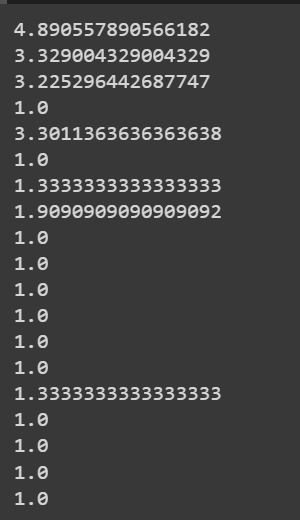

## **Gephi**

Calculating both diameter and average shortest path length gives the same results as with igraph. Gephi also selects the largest subgraph by default 

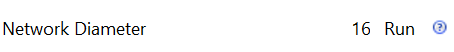

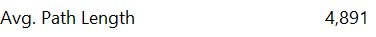

---



## **Answers Q6,7**


6) What is the diameter of the graph? The diameter of the graph is 16. This diameter result might be related to only the biggest graph or an average, as the graph itself is not entirely connected to each nodes. 

7) What is the avg path lenght of the graph? The average shortest path length is around 4.89 for the biggest sub-graph as the graph is not entirely connected. Summing up all avg. shortest path lengths results in around 32. Overall 19 subgraphs were identified.

Directions are not considered as we can regard the graph as undirected as the edge between two actors goes in both directions if they collaborate





---

# Node Importance: Degree centrality



---
**Definition**
Degree centrality is the amount of edges a nodes has. The higher the degree the more central the node is. 


---



(Optional but recommended): Obtain the distribution of the number of movies made by an actor and the number of genres in which an actor starred in. It may be useful to analyze and discuss the results to be obtained in the following exercises.

## Distribution of degree centrality

In [27]:
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure(
    data=[go.Bar(x=edges[:-1], y=hist)],
    layout=go.Layout(
        title='Distribution of Degree',
        xaxis=dict(title='Degree'),
        yaxis=dict(title='Frequency'),
    )
)

fig.show()


## Distribution of movies

In [28]:
#Calculate the distribution of films shot by actors
film_distribution = df_nodes2['movies_95_04'].value_counts()

# print the distribution
print(film_distribution)

10.0     2302
11.0     1853
12.0     1570
13.0     1322
14.0     1149
         ... 
288.0       1
467.0       1
155.0       1
262.0       1
336.0       1
Name: movies_95_04, Length: 194, dtype: int64


In [29]:
import plotly.express as px


fig = px.histogram(df_nodes2, x="movies_95_04",
                   title='Number of movies an actor played in ',
                   labels={'movies_95_04':'Amount of movies actor played in'},
                   color_discrete_sequence=['magenta'] 
                   )
fig.show()

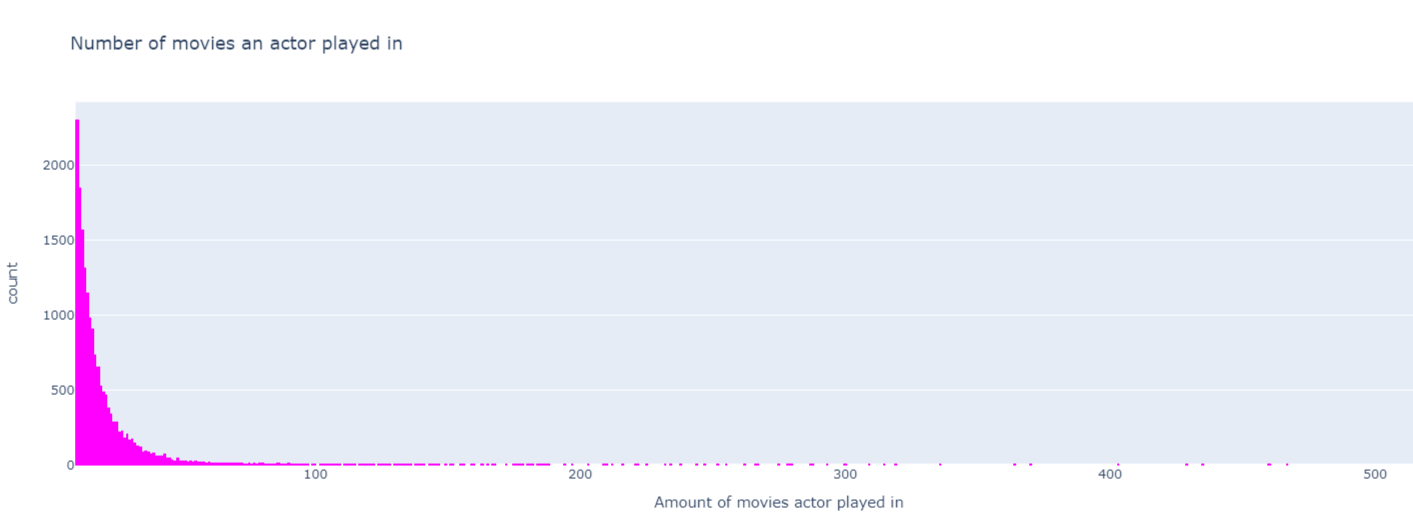

## Distribution of genres

In [30]:
#Calculate the distribution of genres  by actors
genre_distribution = df_nodes2['genre_count'].value_counts()

# print the distribution
print(genre_distribution)

5     3004
6     2816
4     2450
7     2166
8     1531
3     1481
9      929
2      907
1      898
10     561
11     368
12     236
13     117
14      50
15      32
0       17
16      10
17       3
18       1
Name: genre_count, dtype: int64


In [31]:
import plotly.express as px


fig = px.histogram(df_nodes2, x="genre_count",
                   title='Number of genres an actor played in',
                   labels={'genre_count':'Amount genres actor played in'},
                   color_discrete_sequence=['indianred'] 
                   )
fig.show()

The actors play in between 1 to max. 18 different genres. The distribution appears to be normal distributed, but is right skewed. Most of the actors played in movies with 5 different genres

Obtain three vectors with the degree, betweeness and closeness for each vertex of the actors' graph.

Obtain the list of the 20 actors with the largest degree centrality. It can be useful to show a list with the degree, the name of the actor, the number of movies, the main genre, and the number of genres in which the actor has participated.

**8) Who is the actor with highest degree centrality?**

**9) How do you explain the high degree of the top-20 list??**

In [32]:

# calculate the degree centrality of each node
degree = g.degree()

# find the vertex with the highest degree centrality
max_degree = max(degree)
max_index = degree.index(max_degree)

# get the actor name associated with the vertex with highest degree centrality
max_actor = g.vs.select(_degree = max_degree)["ActorName"][0]

# print the result
print("Actor {}, which vertex {}, has the highest degree centrality with a value of {}".format(max_actor, max_index, max_degree))

Actor Davis, Mark (V), which vertex 12147, has the highest degree centrality with a value of 784


In [ ]:
import pandas as pd

#first we are creating a list with all degree and ranking them by degree centrality
sorted_nodes = sorted(list(zip(degree, range(g.vcount()))), reverse=True)

#to store the values a dataframe is created with columns degree centrality and the corresponding index
df_degree_centrality = pd.DataFrame(sorted_nodes, columns=['degree_centrality', 'node_index'])

#additional columns are added to the dataframe based on the graph
#list comprehension is used to extract the corresponding value from the graph with the same node_index
df_degree_centrality['imbd_id'] = [g.vs[node_index]["imbd_id"] for node_index in df_degree_centrality['node_index']]
df_degree_centrality['ActorName'] = [g.vs[node_index]["ActorName"] for node_index in df_degree_centrality['node_index']]
df_degree_centrality['main_genre'] = [g.vs[node_index]["main_genre"] for node_index in df_degree_centrality['node_index']]
df_degree_centrality['movies_95_04'] = [g.vs[node_index]["movies_95_04"] for node_index in df_degree_centrality['node_index']]
df_degree_centrality['genre_count'] = [g.vs[node_index]["genre_count"] for node_index in df_degree_centrality['node_index']]

# the top 20 of the new dataframe are created
top_20 = df_degree_centrality.head(20)

# print the top 20 actors in a dataframe
top_20

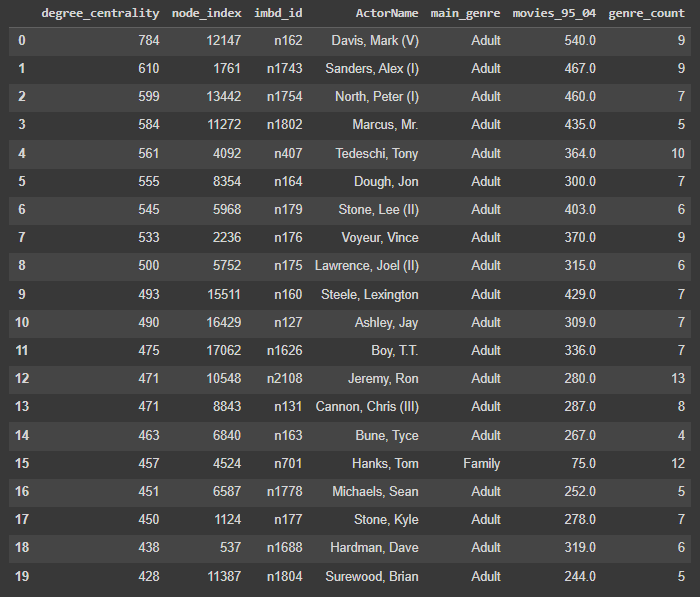

In [ ]:
top_20

---



## **Answers Q8,9**


8) Actor Davis, Mark (V) has the highest centrality degree with 784

9) Almost all of the top 20 actors play in the same genre of "Adult" movies. A high degree of centrality indicates a lot of collaboration with other actors and a certain network. 


**Business rationale for degree centrality**

*   A possible explanation of higher collaboration with actors in this business might be that movies of this genre require less shooting time and would enable actors to produce more collaboration in the same time.
*   Furthermore most of those actors play in 5 different genres, some even up to 11. With that amount of genres, the actor would be meeting a lot of different actors
*    It could also be the case that those actors have smaller parts in roles which enable them to also take more roles. In a further analysis also the screentime per movie per actor should be measured to get a indication of "importance" in the movie. THis could also be used for the "Eigenvector"
*   The expection of the Top 20 and high degree centrality is the actor "Tom Hanks", a well known actor. He is the only one as main genre is not adult movies and playing in less than 100 movies, but is playing in movies with 11 different genres, which helps to connect him with different other actors
*   Even though this information has not been reflected as a attribute most of the actor seem to be male and have a English sounding name. This might be due to the selection of the imbd dataset that focuses more on the North American movie sector. 







---

When visualizing the graph and filtering for the main genre, it can be seen that most of the genres do not determine the grouping of a subgroup. Most of the genres are spread out over the whole graph. With expection to the genre adult movies (seen here in darker green) with strong weights to a few other subgraphs. All of the actors but Tom Hanks can be found in the biggest conglormerate of green nodes. The indication here is that the adult film industry is way more closed in itself when it comes to collaboration than other genres. As an example an actor with a main genre of "drama" or "action" is less likely to have a lot of movies in the adult genre. An explanation for that could be that actors from the adult film industry might be more associated with those roles and have a harder time interacting with actors from other movie genres, nd this sub industry leaves are reputaiton for its actors that make it harder to get other movie offers. 

This is however only an assumption and would need further research if of interest. 

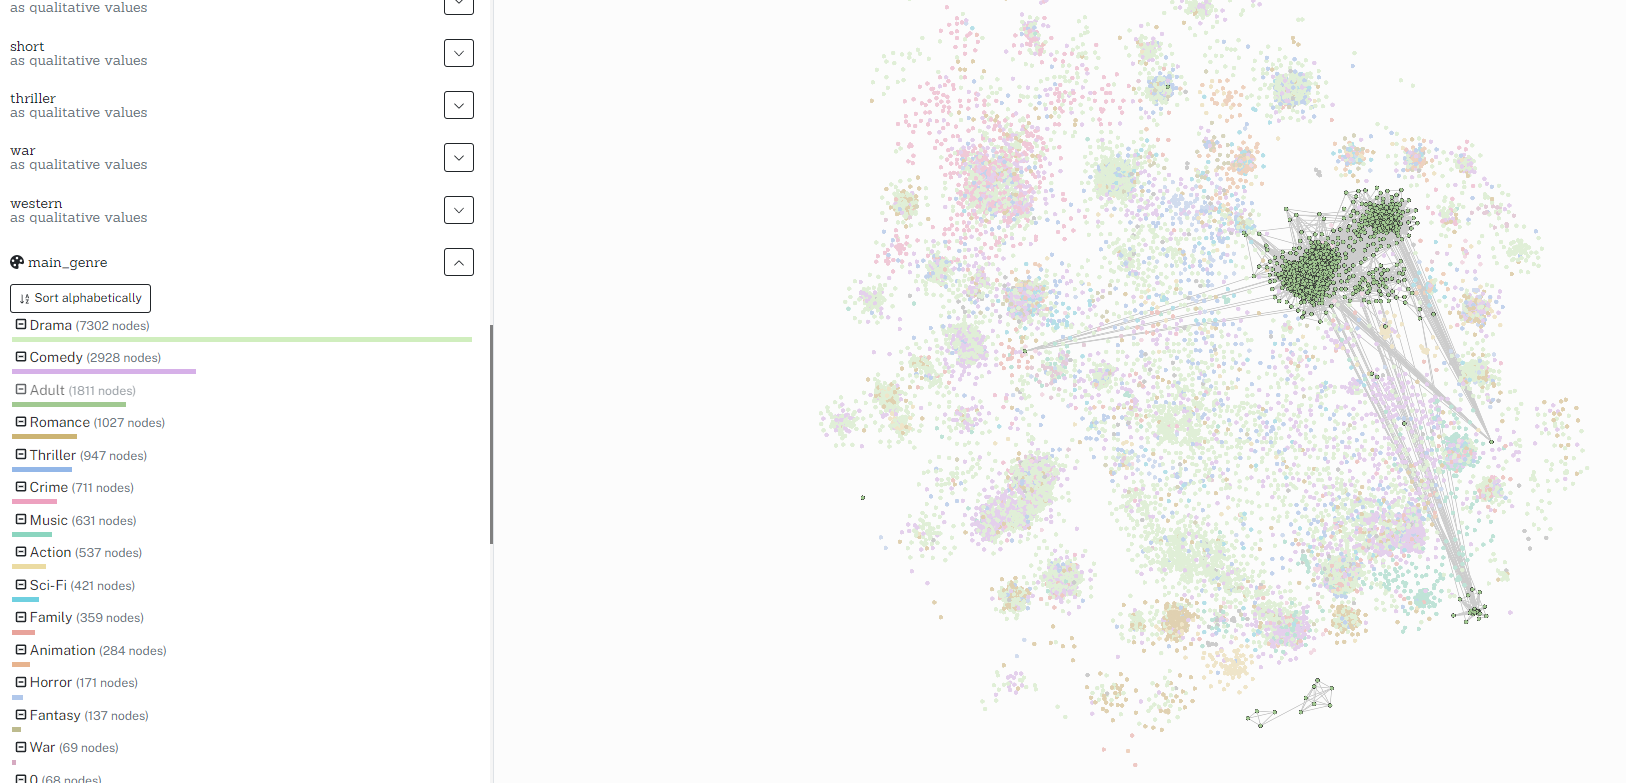

# Node Importance: Betweeness




---
**Definition**
The betweenness centrality measure how often a node appear on shortest paths between nodes in the network




---

Obtain the list of the 20 actors with the largest betweenness centrality. Show a list with the betweenness, the name of the actor, the number of movies, the main genre, and the number of genres in which the actor has participated.

**10) Who is the actor with highest betweenes?**

**11) How do you explain the high betweenness of the top-20 list?**

In [33]:
# Calculate the betweenness centrality of each node
betweenness = g.betweenness()

# Find the node with the maximum betweenness centrality
max_betweenness_node = g.vs['ActorName'][betweenness.index(max(betweenness))]
max_betweenness_genre = g.vs['main_genre'][betweenness.index(max(betweenness))]
max_betweeness = max(betweenness)

# Print the result
print(f"Node with the maximum betweenness centrality: {max_betweenness_node, max_betweenness_genre,max_betweeness}")

Node with the maximum betweenness centrality: ('Jeremy, Ron', 'Adult', 9748544.218901295)


In [34]:
# sort the nodes based on their betweeness in descending order
sorted_nodes_betweenness = sorted(list(zip(betweenness, range(g.vcount()))), reverse=True)

#to store the values a dataframe is created with columns degree centrality and the corresponding index
df_betweenness = pd.DataFrame(sorted_nodes_betweenness, columns=['degree_betweeness', 'node_index'])

#additional columns are added to the dataframe based on the graph
#list comprehension is used to extract the corresponding value from the graph with the same node_index
df_betweenness['imbd_id'] = [g.vs[node_index]["imbd_id"] for node_index in df_betweenness['node_index']]
df_betweenness['ActorName'] = [g.vs[node_index]["ActorName"] for node_index in df_betweenness['node_index']]
df_betweenness['main_genre'] = [g.vs[node_index]["main_genre"] for node_index in df_betweenness['node_index']]
df_betweenness['movies_95_04'] = [g.vs[node_index]["movies_95_04"] for node_index in df_betweenness['node_index']]
df_betweenness['genre_count'] = [g.vs[node_index]["genre_count"] for node_index in df_betweenness['node_index']]

# the top 20 of the new dataframe are created
top_20_betweenness = df_betweenness.head(20)

# print the top 20 actors in a dataframe
top_20_betweenness

degree_betweeness  node_index imbd_id             ActorName main_genre  \
0        9.748544e+06       10548   n2108           Jeremy, Ron      Adult   
1        4.716909e+06        4693   n3284      Chan, Jackie (I)     Comedy   
2        4.330663e+06        2563    n564        Cruz, Penélope      Drama   
3        4.295503e+06       14433  n14458      Shahlavi, Darren     Action   
4        4.267099e+06       15720  n17308  Del Rosario, Monsour     Action   
5        4.037356e+06       17458    n285     Depardieu, Gérard     Comedy   
6        2.570247e+06        8799  n13723     Bachchan, Amitabh    Romance   
7        2.539614e+06       10412   n1529    Jackson, Samuel L.      Drama   
8        2.368164e+06        5517   n5083     Soualem, Zinedine     Comedy   
9        2.316388e+06       15894   n1923       Del Rio, Olivia      Adult   
10       2.136980e+06         559   n2549      Jaenicke, Hannes   Thriller   
11       2.117390e+06       15834   n2623          Hayek, Salma      Drama   
12       2.098485e+06         568  n13698                  Pelé    Romance   
13       2.062585e+06        4157   n4628        Knaup, Herbert      Drama   
14       2.051621e+06        9655   n3213      Goldberg, Whoopi     Comedy   
15       2.019247e+06       13349   n4550         Roth, Cecilia      Drama   
16       2.006221e+06         246   n3075      Bellucci, Monica      Drama   
17       1.977252e+06        4524    n701            Hanks, Tom     Family   
18       1.937362e+06        5906   n1057      August, Pernilla      Drama   
19       1.919261e+06        1531   n5295             Kier, Udo      Drama   

    movies_95_04  genre_count  
0          280.0           13  
1           59.0           11  
2           46.0           12  
3           16.0            9  
4           20.0            8  
5           56.0           10  
6           35.0           12  
7           97.0           13  
8           65.0           11  
9           84.0            5  
10          66.0           11  
11          44.0           13  
12          10.0            3  
13          50.0           10  
14         109.0           13  
15          23.0            7  
16          43.0           11  
17          75.0           12  
18          31.0            9  
19          69.0           14

**Print-out of Top 20 Betweeness**

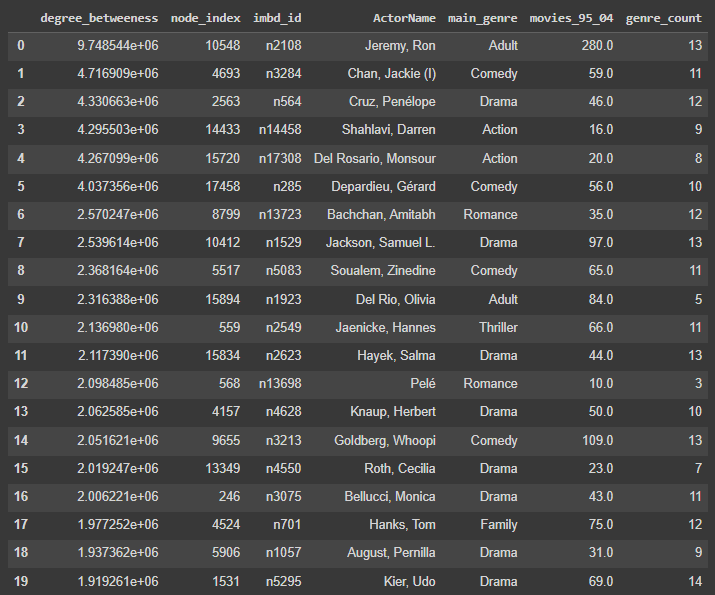

## **Answer Q10,11**



---
10) Actor with highest betweeness
Jeremy,  Ron. The actors Jerme yRoln is well connected with other actors from the main genre of adjult film, but at the same time has direct or indirect connection to other movie gnres as well. Looking at his filmographie he is also listed as a director or producer which explains his high betweeness. Furthermore he has a long lasting movie career which also increased his betweeness during the years of 95 and 2004

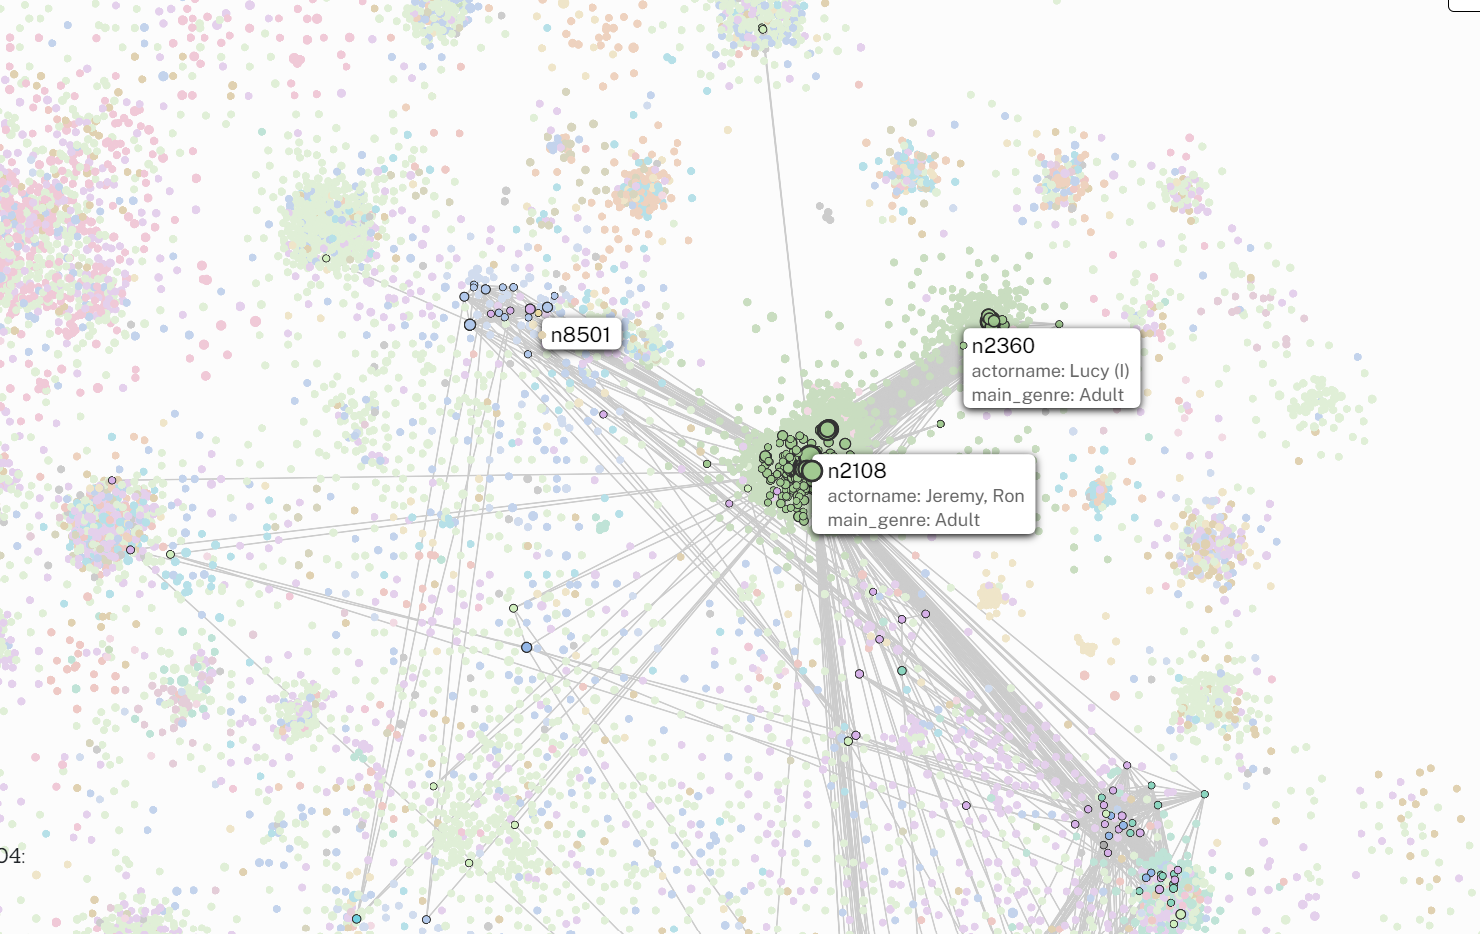


11) Actors with the highest between betweeness?
'Jeremy, Ron', 'Chan, Jackie (I)', 'Cruz, Penélope', 'Shahlavi, Darren', 'Del Rosario, Monsour', 'Depardieu, Gérard', 'Bachchan, Amitabh', 'Jackson, Samuel L.', 'Soualem, Zinedine', 'Del Rio, Olivia', 'Jaenicke, Hannes', 'Hayek, Salma', 'Pelé', 'Knaup, Herbert', 'Goldberg, Whoopi', 'Roth, Cecilia', 'Bellucci, Monica', 'Hanks, Tom', 'August, Pernilla', 'Kier, Udo'

The betweeness is indicating that the actor is well-positioned and has a broker connections between other actors. The actor is located at a critical point, connecting group or cluster of actors. They have a strategic advantage a having a high influence and winning prices as having a high visibility. Compared to the centrality they have less movies than actors above. 

The actors with a high betweeness are in general well know like Penelope Cruz, Samuel L. Jackson, Tom Hanks and Whoopi Goldberg. Those actors have already won the most prestigious award in the movie industry the oscar and other prices. This would be attributes contributing to their "Eigenvector". 

The actor Jeremy Ron also appeared in the Top 20 list of degree centrality. This actor has played mainly in adult movies, but also has a the highest amount of films shot: 280 and a lot of different genres: 11. But researching the actor it was also apparent that he is not only an actor, but also is a producer, writer and director which contributes to his influence and therefore the betweeness. 

Other of those actors do not have worldwide fanbase, but a standing in their domestic movie market, winning domestic movie prices. and could therefore have a high betweenenss in a community.

For further research for each of those actors a list of their prices should be assessed. 

---



**Business Rationale**

When visualizing the graph in gephi with the help of "Retina" we see that some of the well known names like Samuel L. jackson, Salma Hayek or Jackie Chan can be found in short distance to each other. It seems that actors in this area could be classified as belonging to the Hollywood film industry or main blockbusters. What is interesting that each of those actors has connections to different subgraphs showing that even though they all have a reputation in Hollywood (at least between 94-05), they have connections or connections to actors from outside the hollywood inner circle.  What would be worth exploring is also those nodes not in the hollywood inner circe and observe their career path after 2005 to check if they moved to the Hollywood inner circle and what the deciding attributes are. 

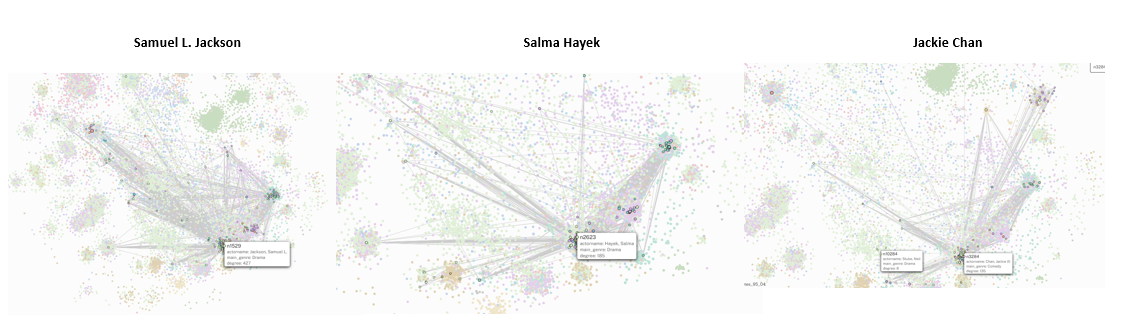

When we looking at other actors that are not directely in the Hollywood inner circle that we just identified but connected to it and also are in the top 20 of betweeness we see for example Gérard Depardieu. The French Actor has many movies in Hollywood itself but at the same time also a big presence in his homecountry. Therefore he has a high level of betweeness between both markets. 

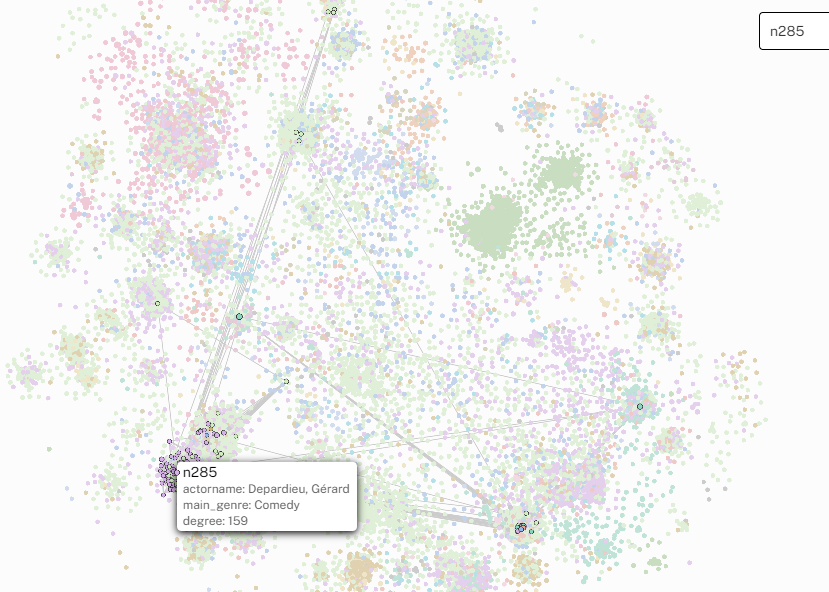

# Node Importance: Closeness



---

**Definition**
Closeness centrality is a way of detecting nodes that are able to spread information very efficienctly trhough a graph. The clseness centlraity of a node measures it average farness to all other nodes. Nodes with a high closenss score have the shoretest distance to all other nodes

---



For the closeness different methods were tried out again as the algorithm would natrually go to a subgraph that has less nodes had here the distances are the smallest and therefore the closeness is the highest.

Obtain the list of the 20 actors with the largest closeness centrality. Show a list with the closeness the name of the actor, the number of movies, the main genre, and the number of genres in which the actor has participated.

**12) Who is the actor with highest closeness centrality?**

**13) How do you explain the high closeness of the top-20 list?**

## **IGraph Basic Closeness**

In [35]:
# Calculate the closenss centrality of each node
closeness = g.closeness()

# Find the node with the maximum betweenness centrality
max_closeness_node = g.vs['ActorName'][closeness.index(max(closeness))]
max_closeness_genre = g.vs['main_genre'][closeness.index(max(closeness))]
max_closeness = max(closeness)

# Print the result
print(f"Node with the maximum closeness centrality: {max_closeness_node, max_closeness_genre,max_closeness}")

Node with the maximum closeness centrality: ('Vischer, Lisa', 'Family', 1.0)


In [36]:
# sort the nodes based on their betweeness in descending order
sorted_nodes_closeness = sorted(list(zip(closeness, range(g.vcount()))), reverse=True)

#to store the values a dataframe is created with columns degree centrality and the corresponding index
df_closeness = pd.DataFrame(sorted_nodes_closeness, columns=['degree_closeness', 'node_index'])

#additional columns are added to the dataframe based on the graph
#list comprehension is used to extract the corresponding value from the graph with the same node_index
df_closeness['imbd_id'] = [g.vs[node_index]["imbd_id"] for node_index in df_closeness['node_index']]
df_closeness['ActorName'] = [g.vs[node_index]["ActorName"] for node_index in df_closeness['node_index']]
df_closeness['main_genre'] = [g.vs[node_index]["main_genre"] for node_index in df_closeness['node_index']]
df_closeness['movies_95_04'] = [g.vs[node_index]["movies_95_04"] for node_index in df_closeness['node_index']]
df_closeness['genre_count'] = [g.vs[node_index]["genre_count"] for node_index in df_closeness['node_index']]

# the top 20 of the new dataframe are created
top_20_closeness = df_closeness.head(30)

# print the top 20 actors in a dataframe
top_20_closeness

degree_closeness  node_index imbd_id          ActorName main_genre  \
0           1.000000       17432  n13307    Doyle, John (I)     Comedy   
1           1.000000       16050  n17737          Zhou, Xun      Drama   
2           1.000000       15732  n17904   Kuusniemi, Matti     Horror   
3           1.000000       15449  n17879     Nawrocki, Mike     Family   
4           1.000000       15166  n17878      Vischer, Phil     Family   
5           1.000000       14206  n17883   Pickhaver, Greig     Comedy   
6           1.000000       12981  n16631   Servais, Manuela      Drama   
7           1.000000       12772  n17865      Mizuki, Arisa      Drama   
8           1.000000       12763  n17777  Sterne, Jeff (II)      Adult   
9           1.000000       12747  n17723       Wang, Zhiwen      Drama   
10          1.000000       11439  n17854        Tork, Hanan    Romance   
11          1.000000       11234  n17775      Kianian, Reza   Thriller   
12          1.000000        9693  n16805    De Neck, Didier      Drama   
13          1.000000        8211  n17786          Neo, Jack     Comedy   
14          1.000000        7258   n7792    Chamish, Leanna     Horror   
15          1.000000        6710  n17855         Zaki, Mona    Romance   
16          1.000000        6281  n17903   Lähde, Ville (I)     Horror   
17          1.000000        4062  n17776         Wood, T.J.      Adult   
18          1.000000        3997   n7793     Stover, George     Sci-Fi   
19          1.000000        3910  n16120   Matsushita, Yuki      Drama   
20          1.000000        3815  n15121      Lawson, Denis      Drama   
21          1.000000        2838   n4049        Fox, Emilia      Drama   
22          1.000000        2815  n17876         Poole, Jim  Animation   
23          1.000000        2586  n17778   Black, Rick (II)      Adult   
24          1.000000        2480  n17882  Walsh, Darren (I)     Comedy   
25          1.000000        2461  n15744  Holt, David (III)     Comedy   
26          1.000000        1814  n13580        Nor, Rosyam    Romance   
27          1.000000        1495  n17633   Shakibai, Khosro      Drama   
28          1.000000         550  n17877      Vischer, Lisa     Family   
29          0.714286        2109  n16747    Armanis, Julian      Adult   

    movies_95_04  genre_count  
0           11.0            2  
1           10.0            4  
2           10.0            5  
3           20.0            3  
4           20.0            3  
5           11.0            2  
6           11.0            3  
7           11.0            3  
8           20.0            1  
9           10.0            3  
10          13.0            3  
11          11.0            3  
12          11.0            5  
13          11.0            5  
14          11.0            7  
15          16.0            5  
16          10.0            5  
17          14.0            1  
18          11.0            5  
19          11.0            3  
20          13.0            7  
21          18.0            8  
22          10.0            3  
23          11.0            1  
24          18.0            4  
25          13.0            6  
26          12.0            3  
27          12.0            2  
28          16.0            3  
29          12.0            2

We can see that the first 29 all have the same value of closeness as 1. Therefore it is hard to pinpoint one actor with a definite closeness. We therefore explore also the possibility of using inverse weighted graphs. Inverse weighted graphs are used as distance and weights are inverse to each other (higher distance, lower weight and vice verse). Therefore we are interested in those weights with lower distance and higher weights.

The first visualization here shows which of the nodes have the highest closeness. We can observe that those nodes on the outside (in light blue) have the highest closness. They are not connected to a big number of other nodes but all next to each other (small distance). 


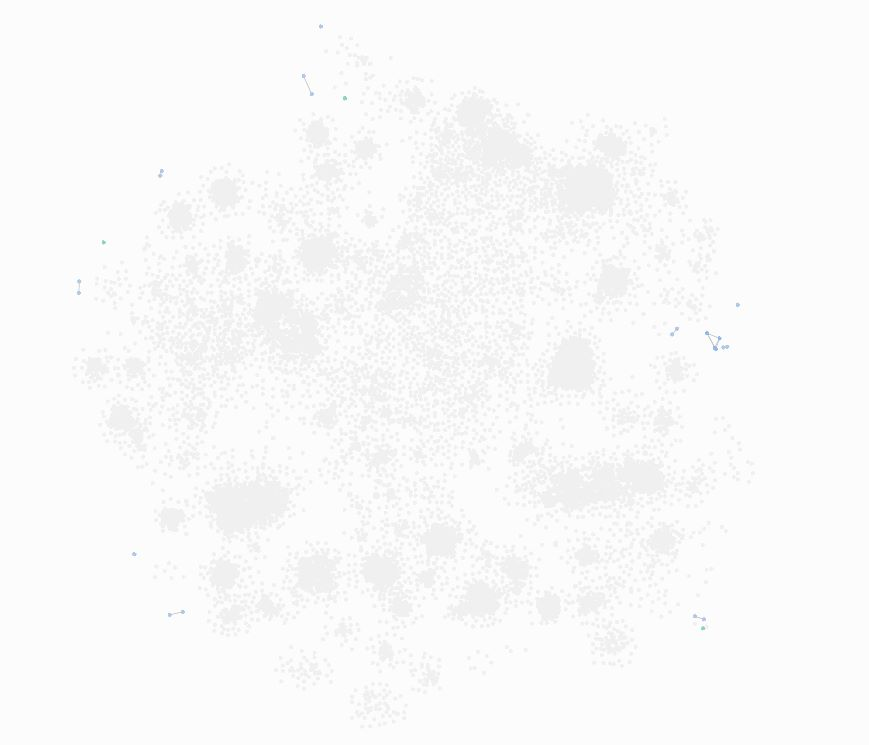

Zooming in on the examples of candiates of the Top 20 list like Xun Zhou, Lisa Vischer or John Doyle we can see that they only are connected to one or two other nodes. 

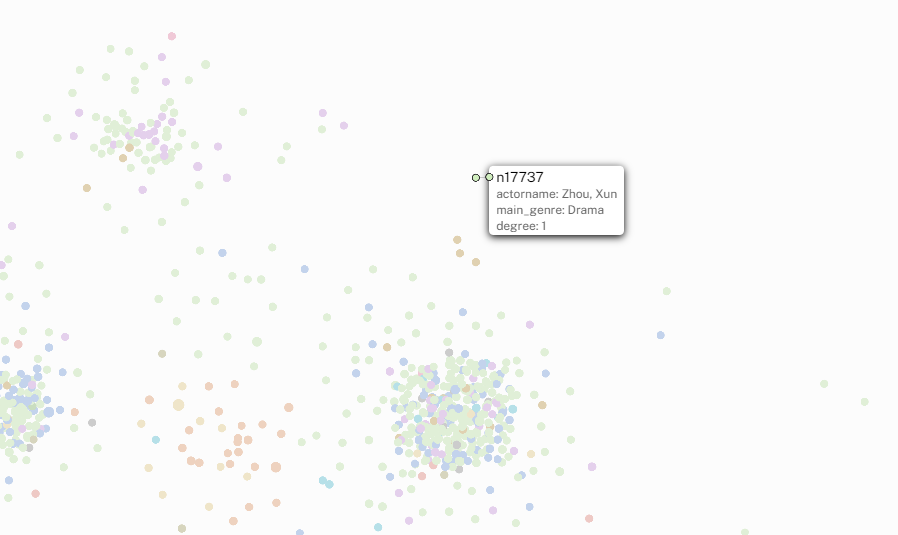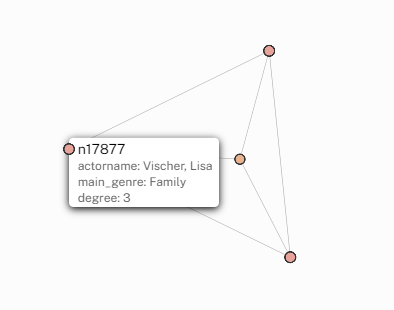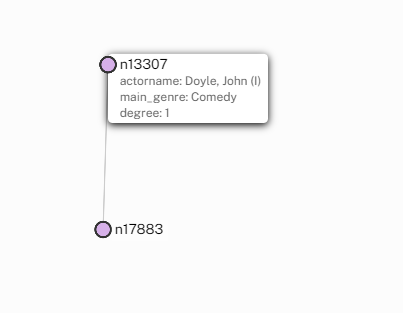

## **IGraph inverted weights**

In [37]:
# invert the weights
inverted_weights = [1/w for w in g.es["weight"]]

In [38]:
wcc = g.closeness(weights=inverted_weights)

# Find the node with the maximum betweenness centrality
max_closeness_node_wcc = g.vs['ActorName'][wcc.index(max(wcc))]
max_closeness_genre_wcc = g.vs['main_genre'][wcc.index(max(wcc))]
max_closeness_wcc = max(wcc)

# Print the result
print(f"Node with the maximum closeness centrality: {max_closeness_node_wcc, max_closeness_genre_wcc,max_closeness_wcc}")

KeyboardInterrupt: ignored

In [ ]:
# sort the nodes based on their betweeness in descending order
sorted_nodes_closeness_wcc = sorted(list(zip(wcc, range(g.vcount()))), reverse=True)

#to store the values a dataframe is created with columns degree centrality and the corresponding index
df_closeness_wcc = pd.DataFrame(sorted_nodes_closeness_wcc, columns=['degree_closeness', 'node_index'])

#additional columns are added to the dataframe based on the graph
#list comprehension is used to extract the corresponding value from the graph with the same node_index
df_closeness_wcc['imbd_id'] = [g.vs[node_index]["imbd_id"] for node_index in df_closeness_wcc['node_index']]
df_closeness_wcc['ActorName'] = [g.vs[node_index]["ActorName"] for node_index in df_closeness_wcc['node_index']]
df_closeness_wcc['main_genre'] = [g.vs[node_index]["main_genre"] for node_index in df_closeness_wcc['node_index']]
df_closeness_wcc['movies_95_04'] = [g.vs[node_index]["movies_95_04"] for node_index in df_closeness_wcc['node_index']]
df_closeness_wcc['genre_count'] = [g.vs[node_index]["genre_count"] for node_index in df_closeness_wcc['node_index']]

# the top 20 of the new dataframe are created
top_20_closeness = df_closeness_wcc.head(20)

# print the top 20 actors in a dataframe
top_20_closeness

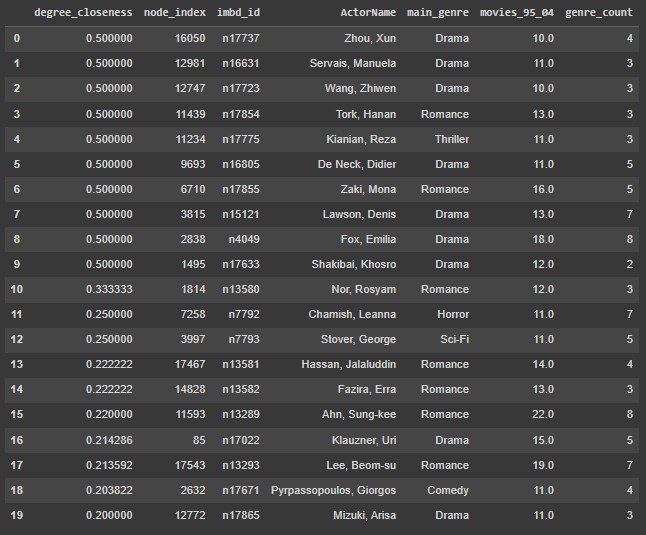

## IGraph biggest subgraph

In [56]:
# create dictionary mapping node IDs to Actor Names
id_to_actor = {v["imbd_id"]: v["ActorName"] for v in g.vs}

# find the largest connected component
components = g.components()
largest_component = max(components, key=len)

# compute closeness centrality for the largest connected component
closeness_largest_graph = g.subgraph(largest_component).closeness()

# find the node with the maximum closeness centrality in the largest connected component
max_closeness_node_name = g.vs['ActorName'][largest_component[closeness_largest_graph.index(max(closeness_largest_graph))]]


print("Node with maximum closeness centrality in the largest connected component:")
print("Actor Name:", max_closeness_node_name)

Node with maximum closeness centrality in the largest connected component:
Actor Name: Jackson, Samuel L.


In [ ]:
closenss_largest= largest_component.closeness(vertices=largest_component.vs, normalized=True)

In [88]:
closeness_df = pd.DataFrame({'id':largest_component.vs['name'],'Closeness':closeness_largest})

In [92]:
merged_df = pd.merge(closeness_df,df_nodes2, on = 'id')

In [93]:
top_actors = merged_df.sort_values('Closeness', ascending=False).head(20).reset_index(drop=True)

In [94]:
top_actors

id  Closeness               ActorName genre_count Action Adult  \
0   n1529   0.309265      Jackson, Samuel L.          13      1     0   
1   n3213   0.307760        Goldberg, Whoopi          13      0     0   
2   n3268   0.305905            Berry, Halle          13      0     0   
3    n503   0.305669           Diaz, Cameron          12      0     1   
4    n701   0.305231              Hanks, Tom          12      0     0   
5    n558   0.304719            Stiller, Ben          13      0     0   
6   n3907   0.302611         Myers, Mike (I)           9      0     0   
7   n3308   0.302606    Douglas, Michael (I)          10      0     0   
8   n2674   0.301217     Lopez, Jennifer (I)          10      0     0   
9    n756   0.300708         De Niro, Robert          12      0     0   
10  n3169   0.300485       Willis, Bruce (I)          13      0     0   
11  n1459   0.300408             Cruise, Tom          10      1     0   
12  n2896   0.299336          Hopper, Dennis          15      1     1   
13   n574   0.298768          Kidman, Nicole          11      0     0   
14  n2714   0.298553         Smith, Will (I)           9      0     0   
15  n3260   0.298548      Washington, Denzel           9      0     0   
16  n3235   0.298512          Travolta, John          12      0     0   
17   n716   0.298359             Madonna (I)          10      0     0   
18   n689   0.297743  Schwarzenegger, Arnold          12      1     0   
19  n3930   0.297581         Hoffman, Dustin          11      0     0   

   Adventure Animation Comedy Crime  ... Mystery Romance Sci-Fi Short  \
0          1         0      1     1  ...       1       0      1     1   
1          1         1      1     0  ...       1       1      1     1   
2          1         0      1     1  ...       1       1      1     1   
3          0         1      1     1  ...       1       1      0     1   
4          0         1      1     0  ...       1       1      0     1   
5          0         1      1     1  ...       1       1      1     1   
6          1         1      1     0  ...       0       1      0     1   
7          0         0      1     1  ...       1       1      0     1   
8          0         0      1     1  ...       0       1      0     1   
9          0         1      1     1  ...       0       0      1     1   
10         1         0      1     1  ...       1       1      1     1   
11         0         0      1     0  ...       1       1      0     1   
12         1         0      1     1  ...       1       1      1     1   
13         0         0      1     1  ...       1       1      0     1   
14         0         0      1     1  ...       0       1      1     1   
15         0         0      1     1  ...       1       0      0     1   
16         1         0      0     1  ...       1       1      1     1   
17         1         0      1     0  ...       0       1      0     1   
18         0         0      1     1  ...       1       1      1     1   
19         0         1      1     0  ...       1       1      0     1   

   Thriller War Western imbd_id main_genre movies_95_04  
0         1   0       0   n1529      Drama         97.0  
1         0   0       0   n3213     Comedy        109.0  
2         1   0       0   n3268     Family         63.0  
3         1   0       0    n503      Drama         59.0  
4         1   1       0    n701     Family         75.0  
5         1   1       0    n558     Comedy         66.0  
6         0   0       0   n3907     Comedy         58.0  
7         1   0       0   n3308     Family         41.0  
8         1   0       0   n2674      Music         68.0  
9         1   1       0    n756     Comedy         51.0  
10        1   1       0   n3169   Thriller         52.0  
11        1   0       0   n1459      Music         46.0  
12        1   0       0   n2896      Music        106.0  
13        1   0       0    n574     Family         54.0  
14        0   0       0   n2714      Music         57.0  
15        1

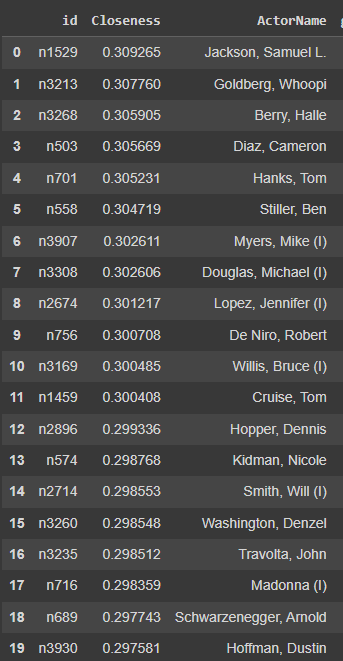

If we take two examples from the visualization like Bruce Willis or Samuel L. Jackson we can see that they have a lot of connection to nodes that are nearby therefore closeness is high. Compared to actors with a high betweeness like Jackie Chan or Salma Hayek they have more edges to nodes from their own community (in this case American movie market) 

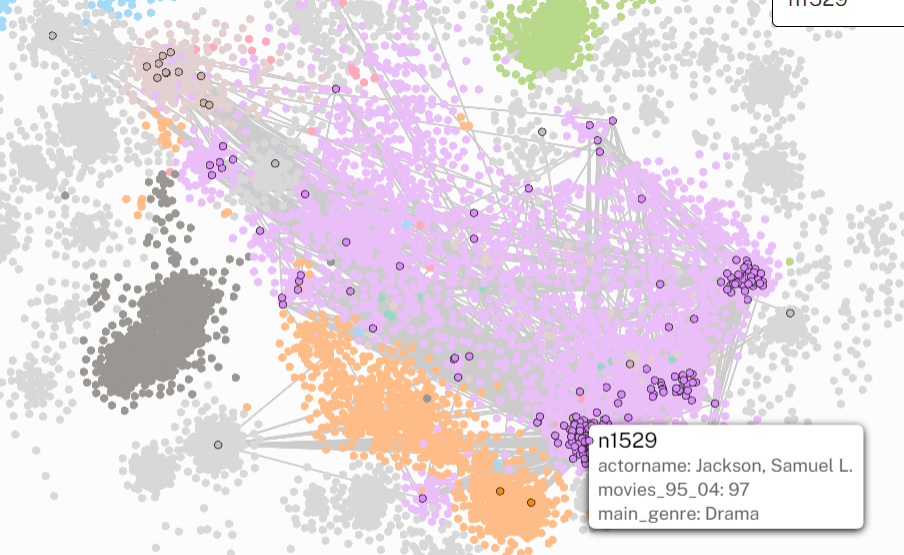

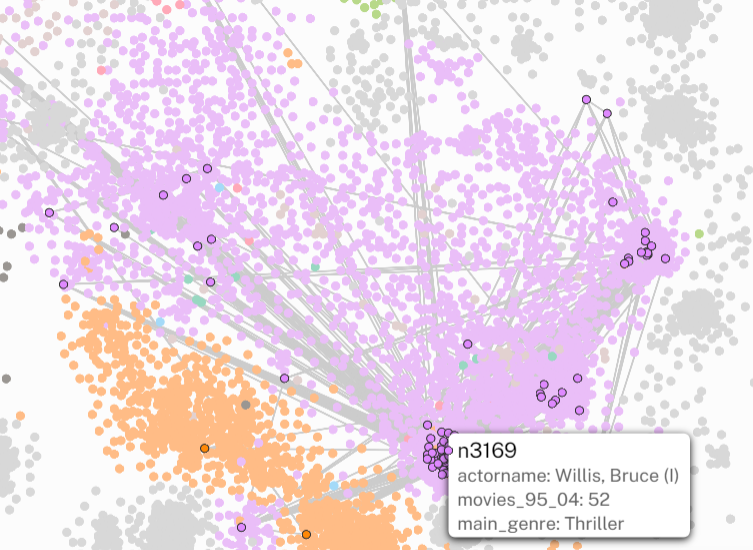



---
## **Answers Q12,13**

12) Who is the actor with highest closeness centrality? In our example without inverted graph it was Lisa Visher, but this is hard to tell as 29 have the same value of 1 in closeness. The maximum closeness for inverted weight graphs has Phil Vischer, but still here are 10 others with the same wcc factor. In case we take only the biggest subgraph we have Samuel L.Jackson as the actor with the highest closeness. 

13) How do you explain the high closeness of the top-20 list? 





**Business Rational for closeness degree**

A high closeness indicates that those actors are well connected and can reach fast other actors. The interpretation for closness can vary based on which subgraph is selected
*   If a smaller subgraph is selected the closness of the actor is explained through the fact that the actor did only shoot with the other actor over the whole 10 years or might be that they do not belong to an independent film industry vs. the bigger subgraphs represent a mainstream movie industry that is divided into different communities

*   In case of the largest subgraph the actor Samuel L. Jackson can be explained as this actor is known for working often with same directors like Quentin Tarentino, who also tends to employ the same actors for different movies.
*  Same for the other actors in the top20 list, those are well known actors from Hollywood. We could argue that actors like Bruce Willis same as Samuel L.Jackson is often working with the same directors or is staring in the same franchise like Die Hard and therefore interacting several times with the same people between 1995 and 2004






 

# Summary



1.   The dataset or graph can be considered quite large given the amount of 287074 nodes and 17577 edges. It is not fully connected and contains 19 subgraphs. 
2.   Visualization: The size of the graph complicated the visualization directly in python, therefore a combination of gephi and retina (online tool was used). 
3. Online visualization: Unfortunately it was not possible to publish the graph on github gist and connect it to the online resources of retina due to the size of the graph that lead to a time out error in github gest. Therefore all visualization were conducted on a local machine. 
4. Degree: Most of the degrees are between 0 and 50 (having collaborated with 50 other actors), the maximum in 724. 
5. The graph was not entirely connected and has 19 sub graphs.
6. For the biggest graph the average shortest path length was 4.89 and the diameter was 16.
7.. Actors with a background in adult movies have the **highest degree centrality** due to the large amount of movies in which they collaborate with more actors in the same time as those of other genres. 
8. Betweeness identifies the most well connected actors. There are various factor that contribute to a **high betweeness** which are if the actor has played in many movies or many genres, but also if this actor played in different markets (e.g. Hollywood and French Cinema Market) and therefore connecting possible communities
9. **Closeness** identified those actors that have a close collaboration with one or two others, but apart from that are not connected too many other actors. In the IMBD graph there were several subgraphs created that were not connected with the main graphs that had the highest level of closness to each other. By default the shortest subgraphs were selected with actros fo the independent movie industry whereas when the larger subgraphs were selected well known actors that are probably collaborating often were shown. 

